# **ResNet Pytorch implementation for FashionMNIST classification**
First we import the required packages.

In [6]:
%matplotlib inline
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import time
import tqdm as tqdm
from torch.autograd import Variable
import pandas as pd

## **Load Dataset**
We can load data from pytorch dataset and preprocess it using *transform* function.

Note that the ResNet implemented in torchvision take RGB images as inputs, which has three channels. So, here we repeat the single-channel grey scale digits image three times to fit the torchvision model.

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                # expand chennel from 1 to 3 to fit 
                                # ResNet pretrained model
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                ]) 
batch_size = 256

# download dataset
mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(len(mnist_train), len(mnist_test))

# Load dataset
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
    shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
    shuffle=True, num_workers=0)

60000 10000


## **Building the model**


In [8]:
# print(models.resnet18())
class ResNetFeatrueExtractor18(nn.Module):
    def __init__(self, pretrained = True):
        super(ResNetFeatrueExtractor18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=pretrained)
        self.conv1 = model_resnet18.conv1
        self.bn1 = model_resnet18.bn1
        self.relu = model_resnet18.relu
        self.maxpool = model_resnet18.maxpool
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4
        self.avgpool = model_resnet18.avgpool

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

class ResClassifier(nn.Module):
    def __init__(self, dropout_p=0.5): #in_features=512
        super(ResClassifier, self).__init__()        
        self.fc = nn.Linear(512, 10)
    def forward(self, x):       
        out = self.fc(x)
        return out

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)

# calculate test accuracy
def test_accuracy(data_iter, netG, netF):
    """Evaluate testset accuracy of a model."""
    acc_sum,n = 0,0
    for (imgs, labels) in data_iter:
        # send data to the GPU if cuda is availabel
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        netG.eval()
        netF.eval()
        with torch.no_grad():
            labels = labels.long()
            acc_sum += torch.sum((torch.argmax(netF(netG(imgs)), dim=1) == labels)).float()
            n += labels.shape[0]
    return acc_sum.item()/n

## **Training using Pre-trained model**

In [9]:
# Initialize empty lists to store metrics
train_losses = []
train_accs = []
valid_accs = []

netG = ResNetFeatrueExtractor18(pretrained = True)
netF = ResClassifier()

if torch.cuda.is_available():
    netG = netG.cuda()
    netF = netF.cuda()

# setting up optimizer for both feature generator G and classifier F.
opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
opt_f = optim.SGD(netF.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(0, 10):
    n, start = 0, time.time()
    train_l_sum = torch.tensor([0.0], dtype=torch.float32)
    train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
    for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
        netG.train()
        netF.train()
        imgs = Variable(imgs)
        labels = Variable(labels)
        # train on GPU if possible  
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            train_l_sum = train_l_sum.cuda()
            train_acc_sum = train_acc_sum.cuda()

        opt_g.zero_grad()
        opt_f.zero_grad()

        # extracted feature
        bottleneck = netG(imgs)     
        
        # predicted labels
        label_hat = netF(bottleneck)

        # loss function
        loss= criterion(label_hat, labels)
        loss.backward()
        opt_g.step()
        opt_f.step()
        
        # calcualte training error
        netG.eval()
        netF.eval()
        labels = labels.long()
        train_l_sum += loss.float()
        train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
        n += labels.shape[0]
    test_acc = test_accuracy(iter(test_loader), netG, netF) 
    train_losses.append((train_l_sum/n).cpu().item() if torch.cuda.is_available() else (train_l_sum/n).item())
    train_accs.append((train_acc_sum/n).cpu().item() if torch.cuda.is_available() else (train_acc_sum/n).item())
    valid_accs.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
        % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))


/cluster/home/aliw/Projects/EchoRapp/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/aliw/Projects/EchoRapp/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
235it [00:13, 17.72it/s]


epoch 1, loss 0.0020, train acc 0.821, test acc 0.869, time 15.2 sec


235it [00:13, 17.86it/s]


epoch 2, loss 0.0011, train acc 0.893, test acc 0.868, time 15.1 sec


235it [00:13, 17.32it/s]


epoch 3, loss 0.0009, train acc 0.913, test acc 0.894, time 15.5 sec


235it [00:13, 17.38it/s]


epoch 4, loss 0.0008, train acc 0.927, test acc 0.889, time 15.4 sec


235it [00:13, 17.43it/s]


epoch 5, loss 0.0007, train acc 0.937, test acc 0.892, time 15.4 sec


235it [00:13, 17.44it/s]


epoch 6, loss 0.0006, train acc 0.947, test acc 0.895, time 15.4 sec


235it [00:14, 16.39it/s]


epoch 7, loss 0.0005, train acc 0.954, test acc 0.878, time 16.4 sec


235it [00:14, 16.51it/s]


epoch 8, loss 0.0004, train acc 0.963, test acc 0.896, time 16.1 sec


235it [00:14, 16.72it/s]


epoch 9, loss 0.0003, train acc 0.969, test acc 0.896, time 16.1 sec


235it [00:14, 16.64it/s]


epoch 10, loss 0.0003, train acc 0.974, test acc 0.891, time 16.0 sec


## **Training without Pre-trained model**
The training with pre-trained model is around 2% better than the non-pre-trained model, as Fashion is a more complicated dataset.

In [10]:
netG = ResNetFeatrueExtractor18(pretrained = False)
netF = ResClassifier()

if torch.cuda.is_available():
    netG = netG.cuda()
    netF = netF.cuda()

# setting up optimizer for both feature generator G and classifier F.
opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
opt_f = optim.SGD(netF.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(0, 2):
    n, start = 0, time.time()
    train_l_sum = torch.tensor([0.0], dtype=torch.float32)
    train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
    for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
        netG.train()
        netF.train()
        imgs = Variable(imgs)
        labels = Variable(labels)
        # train on GPU if possible  
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            train_l_sum = train_l_sum.cuda()
            train_acc_sum = train_acc_sum.cuda()

        opt_g.zero_grad()
        opt_f.zero_grad()

        # extracted feature
        bottleneck = netG(imgs)     
        
        # predicted labels
        label_hat = netF(bottleneck)

        # loss function
        loss= criterion(label_hat, labels)
        loss.backward()
        opt_g.step()
        opt_f.step()
        
        # calcualte training error
        netG.eval()
        netF.eval()
        labels = labels.long()
        train_l_sum += loss.float()
        train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
        n += labels.shape[0]
    test_acc = test_accuracy(iter(test_loader), netG, netF) 
    train_losses.append((train_l_sum/n).cpu().item() if torch.cuda.is_available() else (train_l_sum/n).item())
    train_accs.append((train_acc_sum/n).cpu().item() if torch.cuda.is_available() else (train_acc_sum/n).item())
    valid_accs.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
        % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

/cluster/home/aliw/Projects/EchoRapp/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
235it [00:14, 16.56it/s]


epoch 1, loss 0.0021, train acc 0.804, test acc 0.834, time 16.1 sec


235it [00:13, 16.91it/s]


epoch 2, loss 0.0013, train acc 0.875, test acc 0.857, time 15.8 sec


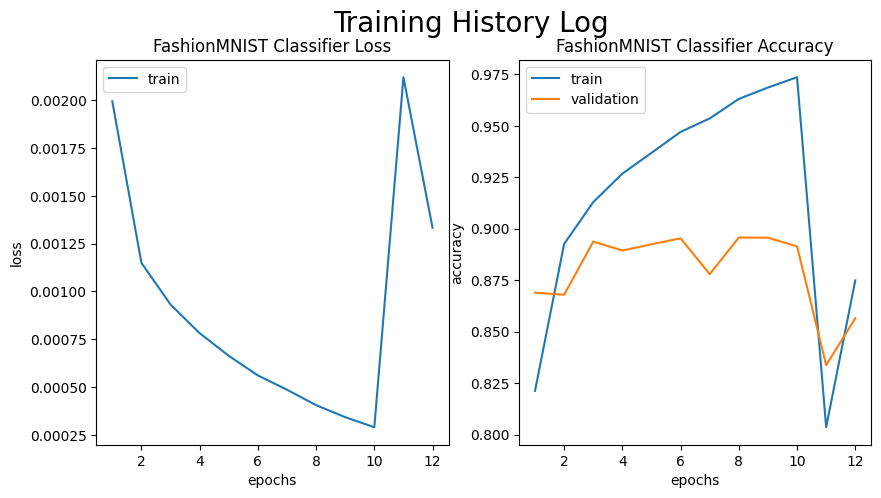

In [11]:
# After both training loops, create the history DataFrame
history = pd.DataFrame({
    'train_loss': train_losses,
    'train_acc': train_accs,
    'valid_acc': valid_accs,
    # We don't have validation loss values in the original code
    'valid_loss': [None] * len(train_losses)  # You could estimate this if needed
})

# Now fix the plotting code:
history.index = [idx for idx in range(1, history.shape[0]+1)]  # from first epoch
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Training History Log', size=20)

# Plot loss
axs[0].plot(history["train_loss"], label="train")
if not all(x is None for x in history["valid_loss"]):  # Only plot if we have values
    axs[0].plot(history["valid_loss"], label="validation")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title('FashionMNIST Classifier Loss')

# Plot accuracy
axs[1].plot(history["train_acc"], label="train")
axs[1].plot(history["valid_acc"], label="validation")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].set_title('FashionMNIST Classifier Accuracy')

plt.show()